# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [15]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

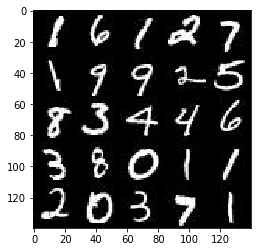

In [16]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

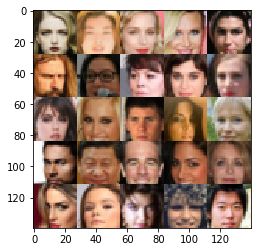

In [17]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [18]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [19]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name = 'input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name = 'input_z')
    learning_rate = tf.placeholder(tf.float32, name = 'learning_rate')
    
    return inputs_real, inputs_z, learning_rate
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [20]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides = 2, padding = 'same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64

        x2 = tf.layers.conv2d(relu1, 128, 5, strides = 2, padding = 'same')
        bn2 = tf.layers.batch_normalization(x2, training = True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128

        x3 = tf.layers.conv2d(relu2, 256, 5, strides = 2, padding = 'same')
        bn3 = tf.layers.batch_normalization(x3, training = True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [21]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    if is_train:
        _reuse = False
    else:
        _reuse = True
    
    alpha=0.2
    
    with tf.variable_scope('generator', reuse = _reuse):
        
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training = is_train)
        x1 = tf.maximum(alpha * x1, x1)
        print("x1 Shape = {}".format(x1.shape))
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding = 'same')
        x2 = tf.layers.batch_normalization(x2, training = is_train)
        x2 = tf.maximum(alpha * x2, x2)
        print("x2 Shape = {}".format(x2.shape))
        # 14x14x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding = 'same')
        x3 = tf.layers.batch_normalization(x3, training = is_train)
        x3 = tf.maximum(alpha * x3, x3)
        print("x3 Shape = {}".format(x3.shape))
        # 28x28x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding = 'same')
        print("Output Shape = {}".format(logits.shape))
        # 28x28x3 now
        
        out = tf.tanh(logits)    
    
       
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

x1 Shape = (?, 7, 7, 512)
x2 Shape = (?, 14, 14, 256)
x3 Shape = (?, 28, 28, 128)
Output Shape = (?, 28, 28, 5)
x1 Shape = (?, 7, 7, 512)
x2 Shape = (?, 14, 14, 256)
x3 Shape = (?, 28, 28, 128)
Output Shape = (?, 28, 28, 5)
Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [22]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function    
    smooth = 0.1
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse = True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits = d_logits_real, 
            labels = tf.ones_like(d_model_real) * (1 - smooth)))

    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake, labels = tf.zeros_like(d_model_fake)))
        
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake, labels = tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
        
        
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

x1 Shape = (?, 7, 7, 512)
x2 Shape = (?, 14, 14, 256)
x3 Shape = (?, 28, 28, 128)
Output Shape = (?, 28, 28, 4)
Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [23]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate = learning_rate, beta1 = beta1)\
                                .minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate = learning_rate, beta1 = beta1)\
                                .minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [24]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [45]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    # if it's gray level, data_shape[3] = 1 while for a RGB, data_shape[3] = 3
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]
    
    input_real, input_z, _learning_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)    
    
    
    # Logging
    print_every=10
    show_every=100 # It's recommended to print the generator output every 100 batches.
    n_images = 16
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2
                
                # Sample random noise
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                # Generator and Discriminator Training Frequency Ratio: 5:1
                _ = sess.run(d_train_opt, feed_dict = 
                                        { input_real: batch_images, 
                                          input_z: batch_z,
                                          _learning_rate: learning_rate
                                        })
                
                _ = sess.run(g_train_opt, feed_dict = 
                                        { input_z: batch_z, 
                                          input_real: batch_images,
                                          _learning_rate: learning_rate
                                        }) 
    
            
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                   
                if steps % show_every == 0:
                    show_generator_output(sess, n_images, input_z, data_shape[3], data_image_mode)                
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

x1 Shape = (?, 7, 7, 512)
x2 Shape = (?, 14, 14, 256)
x3 Shape = (?, 28, 28, 128)
Output Shape = (?, 28, 28, 1)
Epoch 1/2... Discriminator Loss: 0.3922... Generator Loss: 3.7353
Epoch 1/2... Discriminator Loss: 0.3913... Generator Loss: 3.8139
Epoch 1/2... Discriminator Loss: 0.3699... Generator Loss: 4.1218
Epoch 1/2... Discriminator Loss: 0.3899... Generator Loss: 9.1978
Epoch 1/2... Discriminator Loss: 1.4904... Generator Loss: 8.8825
Epoch 1/2... Discriminator Loss: 0.7373... Generator Loss: 5.8550
Epoch 1/2... Discriminator Loss: 0.7310... Generator Loss: 2.4078
Epoch 1/2... Discriminator Loss: 0.7389... Generator Loss: 1.9725
Epoch 1/2... Discriminator Loss: 1.9990... Generator Loss: 0.2774
Epoch 1/2... Discriminator Loss: 1.0005... Generator Loss: 1.2725
x1 Shape = (?, 7, 7, 512)
x2 Shape = (?, 14, 14, 256)
x3 Shape = (?, 28, 28, 128)
Output Shape = (?, 28, 28, 1)


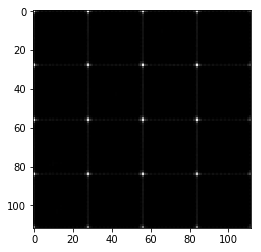

Epoch 1/2... Discriminator Loss: 1.1173... Generator Loss: 1.4096
Epoch 1/2... Discriminator Loss: 1.2935... Generator Loss: 2.0410
Epoch 1/2... Discriminator Loss: 1.2974... Generator Loss: 1.2604
Epoch 1/2... Discriminator Loss: 1.1315... Generator Loss: 1.2086
Epoch 1/2... Discriminator Loss: 1.3754... Generator Loss: 0.9112
Epoch 1/2... Discriminator Loss: 1.3246... Generator Loss: 0.5904
Epoch 1/2... Discriminator Loss: 1.0312... Generator Loss: 1.3717
Epoch 1/2... Discriminator Loss: 1.3308... Generator Loss: 0.6361
Epoch 1/2... Discriminator Loss: 1.0428... Generator Loss: 1.1615
Epoch 1/2... Discriminator Loss: 1.3468... Generator Loss: 1.7250
x1 Shape = (?, 7, 7, 512)
x2 Shape = (?, 14, 14, 256)
x3 Shape = (?, 28, 28, 128)
Output Shape = (?, 28, 28, 1)


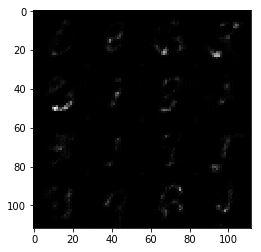

Epoch 1/2... Discriminator Loss: 1.1220... Generator Loss: 1.0188
Epoch 1/2... Discriminator Loss: 1.0827... Generator Loss: 1.0690
Epoch 1/2... Discriminator Loss: 1.1459... Generator Loss: 1.5048
Epoch 1/2... Discriminator Loss: 1.0701... Generator Loss: 0.9733
Epoch 1/2... Discriminator Loss: 1.0497... Generator Loss: 1.0336
Epoch 1/2... Discriminator Loss: 1.1050... Generator Loss: 0.9352
Epoch 1/2... Discriminator Loss: 1.4178... Generator Loss: 0.4922
Epoch 1/2... Discriminator Loss: 1.1283... Generator Loss: 1.5713
Epoch 1/2... Discriminator Loss: 1.2026... Generator Loss: 0.6853
Epoch 1/2... Discriminator Loss: 1.1461... Generator Loss: 0.7276
x1 Shape = (?, 7, 7, 512)
x2 Shape = (?, 14, 14, 256)
x3 Shape = (?, 28, 28, 128)
Output Shape = (?, 28, 28, 1)


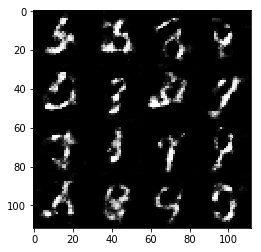

Epoch 1/2... Discriminator Loss: 1.1391... Generator Loss: 1.4576
Epoch 1/2... Discriminator Loss: 1.1481... Generator Loss: 0.8110
Epoch 1/2... Discriminator Loss: 0.9811... Generator Loss: 1.4380
Epoch 1/2... Discriminator Loss: 1.0601... Generator Loss: 1.0933
Epoch 1/2... Discriminator Loss: 1.1858... Generator Loss: 0.6556
Epoch 1/2... Discriminator Loss: 1.3095... Generator Loss: 0.6160
Epoch 1/2... Discriminator Loss: 1.0201... Generator Loss: 1.2161
Epoch 1/2... Discriminator Loss: 1.0949... Generator Loss: 1.3338
Epoch 1/2... Discriminator Loss: 1.2476... Generator Loss: 0.6299
Epoch 1/2... Discriminator Loss: 1.5054... Generator Loss: 0.4464
x1 Shape = (?, 7, 7, 512)
x2 Shape = (?, 14, 14, 256)
x3 Shape = (?, 28, 28, 128)
Output Shape = (?, 28, 28, 1)


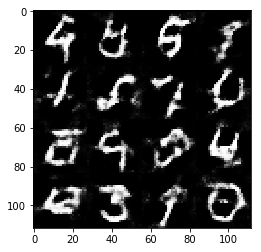

Epoch 1/2... Discriminator Loss: 1.1487... Generator Loss: 1.5669
Epoch 1/2... Discriminator Loss: 1.1315... Generator Loss: 0.7827
Epoch 1/2... Discriminator Loss: 1.1460... Generator Loss: 1.1712
Epoch 1/2... Discriminator Loss: 1.1401... Generator Loss: 1.4396
Epoch 1/2... Discriminator Loss: 1.2790... Generator Loss: 0.6024
Epoch 1/2... Discriminator Loss: 1.0290... Generator Loss: 1.0513
Epoch 2/2... Discriminator Loss: 1.2002... Generator Loss: 1.6159
Epoch 2/2... Discriminator Loss: 1.2036... Generator Loss: 1.5819
Epoch 2/2... Discriminator Loss: 1.0972... Generator Loss: 1.0124
Epoch 2/2... Discriminator Loss: 1.1506... Generator Loss: 0.7521
x1 Shape = (?, 7, 7, 512)
x2 Shape = (?, 14, 14, 256)
x3 Shape = (?, 28, 28, 128)
Output Shape = (?, 28, 28, 1)


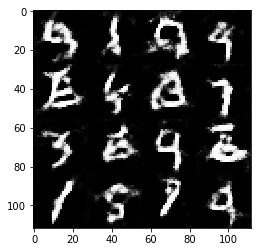

Epoch 2/2... Discriminator Loss: 1.1631... Generator Loss: 0.7419
Epoch 2/2... Discriminator Loss: 1.0455... Generator Loss: 0.9482
Epoch 2/2... Discriminator Loss: 1.0134... Generator Loss: 1.1399
Epoch 2/2... Discriminator Loss: 1.1687... Generator Loss: 1.4390
Epoch 2/2... Discriminator Loss: 1.2275... Generator Loss: 1.3995
Epoch 2/2... Discriminator Loss: 1.1424... Generator Loss: 1.7265
Epoch 2/2... Discriminator Loss: 0.9879... Generator Loss: 1.3948
Epoch 2/2... Discriminator Loss: 1.1436... Generator Loss: 1.6617
Epoch 2/2... Discriminator Loss: 1.1809... Generator Loss: 1.4602
Epoch 2/2... Discriminator Loss: 1.0755... Generator Loss: 1.0042
x1 Shape = (?, 7, 7, 512)
x2 Shape = (?, 14, 14, 256)
x3 Shape = (?, 28, 28, 128)
Output Shape = (?, 28, 28, 1)


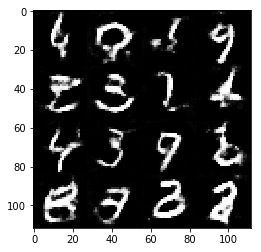

Epoch 2/2... Discriminator Loss: 1.0046... Generator Loss: 1.0390
Epoch 2/2... Discriminator Loss: 1.0623... Generator Loss: 1.4133
Epoch 2/2... Discriminator Loss: 1.1725... Generator Loss: 0.6689
Epoch 2/2... Discriminator Loss: 1.1698... Generator Loss: 0.7003
Epoch 2/2... Discriminator Loss: 0.9747... Generator Loss: 1.4507
Epoch 2/2... Discriminator Loss: 1.0208... Generator Loss: 0.9974
Epoch 2/2... Discriminator Loss: 1.0125... Generator Loss: 1.4340
Epoch 2/2... Discriminator Loss: 1.3556... Generator Loss: 2.1831
Epoch 2/2... Discriminator Loss: 1.3426... Generator Loss: 0.5208
Epoch 2/2... Discriminator Loss: 0.9767... Generator Loss: 1.0643
x1 Shape = (?, 7, 7, 512)
x2 Shape = (?, 14, 14, 256)
x3 Shape = (?, 28, 28, 128)
Output Shape = (?, 28, 28, 1)


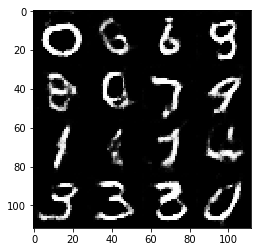

Epoch 2/2... Discriminator Loss: 0.9336... Generator Loss: 1.1356
Epoch 2/2... Discriminator Loss: 1.1401... Generator Loss: 2.9260
Epoch 2/2... Discriminator Loss: 1.1033... Generator Loss: 0.8184
Epoch 2/2... Discriminator Loss: 0.9879... Generator Loss: 0.8981
Epoch 2/2... Discriminator Loss: 1.0311... Generator Loss: 0.8816
Epoch 2/2... Discriminator Loss: 1.3527... Generator Loss: 0.5261
Epoch 2/2... Discriminator Loss: 1.2594... Generator Loss: 0.6242
Epoch 2/2... Discriminator Loss: 1.0573... Generator Loss: 0.8475
Epoch 2/2... Discriminator Loss: 0.9760... Generator Loss: 1.0703
Epoch 2/2... Discriminator Loss: 0.9346... Generator Loss: 1.1832
x1 Shape = (?, 7, 7, 512)
x2 Shape = (?, 14, 14, 256)
x3 Shape = (?, 28, 28, 128)
Output Shape = (?, 28, 28, 1)


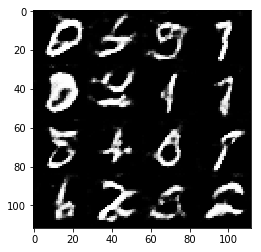

Epoch 2/2... Discriminator Loss: 1.1229... Generator Loss: 0.7522
Epoch 2/2... Discriminator Loss: 1.1062... Generator Loss: 1.8795
Epoch 2/2... Discriminator Loss: 1.0050... Generator Loss: 0.9235
Epoch 2/2... Discriminator Loss: 0.9321... Generator Loss: 1.1639
Epoch 2/2... Discriminator Loss: 1.0243... Generator Loss: 0.8987
Epoch 2/2... Discriminator Loss: 1.0321... Generator Loss: 1.5579
Epoch 2/2... Discriminator Loss: 0.9094... Generator Loss: 1.4016
Epoch 2/2... Discriminator Loss: 0.8240... Generator Loss: 1.2712
Epoch 2/2... Discriminator Loss: 1.0287... Generator Loss: 1.6121
Epoch 2/2... Discriminator Loss: 0.9612... Generator Loss: 1.2621
x1 Shape = (?, 7, 7, 512)
x2 Shape = (?, 14, 14, 256)
x3 Shape = (?, 28, 28, 128)
Output Shape = (?, 28, 28, 1)


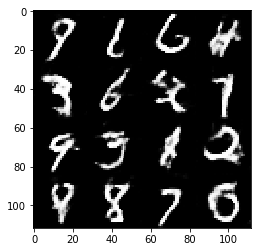

Epoch 2/2... Discriminator Loss: 1.0650... Generator Loss: 0.7897
Epoch 2/2... Discriminator Loss: 1.9028... Generator Loss: 2.1425
Epoch 2/2... Discriminator Loss: 1.1740... Generator Loss: 0.7180


In [46]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

x1 Shape = (?, 7, 7, 512)
x2 Shape = (?, 14, 14, 256)
x3 Shape = (?, 28, 28, 128)
Output Shape = (?, 28, 28, 3)
Epoch 1/1... Discriminator Loss: 0.9305... Generator Loss: 1.3884
Epoch 1/1... Discriminator Loss: 0.7474... Generator Loss: 2.5532
Epoch 1/1... Discriminator Loss: 0.6796... Generator Loss: 1.5362
Epoch 1/1... Discriminator Loss: 1.0955... Generator Loss: 3.3376
Epoch 1/1... Discriminator Loss: 0.9826... Generator Loss: 1.1417
Epoch 1/1... Discriminator Loss: 2.1058... Generator Loss: 0.2652
Epoch 1/1... Discriminator Loss: 0.9360... Generator Loss: 1.4941
Epoch 1/1... Discriminator Loss: 0.7249... Generator Loss: 1.5674
Epoch 1/1... Discriminator Loss: 0.8677... Generator Loss: 3.7843
Epoch 1/1... Discriminator Loss: 0.5160... Generator Loss: 3.2157
x1 Shape = (?, 7, 7, 512)
x2 Shape = (?, 14, 14, 256)
x3 Shape = (?, 28, 28, 128)
Output Shape = (?, 28, 28, 3)


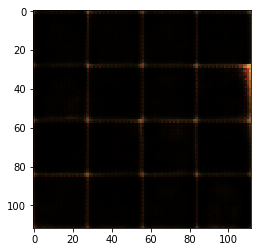

Epoch 1/1... Discriminator Loss: 0.6063... Generator Loss: 2.1354
Epoch 1/1... Discriminator Loss: 1.0862... Generator Loss: 4.5262
Epoch 1/1... Discriminator Loss: 0.4589... Generator Loss: 2.8494
Epoch 1/1... Discriminator Loss: 0.7854... Generator Loss: 1.3032
Epoch 1/1... Discriminator Loss: 0.6001... Generator Loss: 1.8118
Epoch 1/1... Discriminator Loss: 0.6420... Generator Loss: 1.6757
Epoch 1/1... Discriminator Loss: 1.4733... Generator Loss: 0.4858
Epoch 1/1... Discriminator Loss: 0.6495... Generator Loss: 2.1844
Epoch 1/1... Discriminator Loss: 0.4765... Generator Loss: 2.6167
Epoch 1/1... Discriminator Loss: 1.5018... Generator Loss: 0.5722
x1 Shape = (?, 7, 7, 512)
x2 Shape = (?, 14, 14, 256)
x3 Shape = (?, 28, 28, 128)
Output Shape = (?, 28, 28, 3)


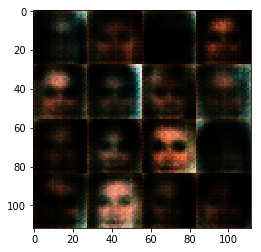

Epoch 1/1... Discriminator Loss: 0.7946... Generator Loss: 1.3015
Epoch 1/1... Discriminator Loss: 1.5755... Generator Loss: 3.2845
Epoch 1/1... Discriminator Loss: 0.8245... Generator Loss: 1.3671
Epoch 1/1... Discriminator Loss: 0.9297... Generator Loss: 2.5758
Epoch 1/1... Discriminator Loss: 0.8826... Generator Loss: 2.5874
Epoch 1/1... Discriminator Loss: 1.2861... Generator Loss: 1.0981
Epoch 1/1... Discriminator Loss: 0.8602... Generator Loss: 1.9524
Epoch 1/1... Discriminator Loss: 1.0521... Generator Loss: 0.8701
Epoch 1/1... Discriminator Loss: 1.0355... Generator Loss: 1.0173
Epoch 1/1... Discriminator Loss: 1.5954... Generator Loss: 0.4094
x1 Shape = (?, 7, 7, 512)
x2 Shape = (?, 14, 14, 256)
x3 Shape = (?, 28, 28, 128)
Output Shape = (?, 28, 28, 3)


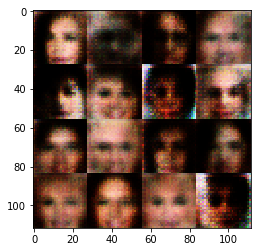

Epoch 1/1... Discriminator Loss: 1.1693... Generator Loss: 2.2385
Epoch 1/1... Discriminator Loss: 0.7401... Generator Loss: 2.4454
Epoch 1/1... Discriminator Loss: 0.9302... Generator Loss: 1.2386
Epoch 1/1... Discriminator Loss: 2.5754... Generator Loss: 0.1475
Epoch 1/1... Discriminator Loss: 1.6770... Generator Loss: 0.4046
Epoch 1/1... Discriminator Loss: 1.0166... Generator Loss: 0.8454
Epoch 1/1... Discriminator Loss: 0.9760... Generator Loss: 3.8043
Epoch 1/1... Discriminator Loss: 0.6220... Generator Loss: 3.6447
Epoch 1/1... Discriminator Loss: 1.2068... Generator Loss: 0.8422
Epoch 1/1... Discriminator Loss: 1.1008... Generator Loss: 1.8699
x1 Shape = (?, 7, 7, 512)
x2 Shape = (?, 14, 14, 256)
x3 Shape = (?, 28, 28, 128)
Output Shape = (?, 28, 28, 3)


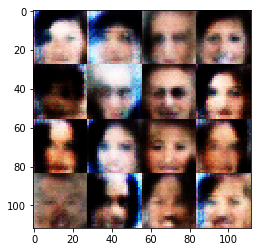

Epoch 1/1... Discriminator Loss: 1.0186... Generator Loss: 0.9081
Epoch 1/1... Discriminator Loss: 0.8616... Generator Loss: 1.3606
Epoch 1/1... Discriminator Loss: 0.6578... Generator Loss: 3.1547
Epoch 1/1... Discriminator Loss: 0.5625... Generator Loss: 3.5543
Epoch 1/1... Discriminator Loss: 0.6640... Generator Loss: 1.5126
Epoch 1/1... Discriminator Loss: 0.4988... Generator Loss: 2.3839
Epoch 1/1... Discriminator Loss: 1.1862... Generator Loss: 0.7313
Epoch 1/1... Discriminator Loss: 0.7774... Generator Loss: 2.3187
Epoch 1/1... Discriminator Loss: 0.8891... Generator Loss: 1.0565
Epoch 1/1... Discriminator Loss: 1.9005... Generator Loss: 1.8112
x1 Shape = (?, 7, 7, 512)
x2 Shape = (?, 14, 14, 256)
x3 Shape = (?, 28, 28, 128)
Output Shape = (?, 28, 28, 3)


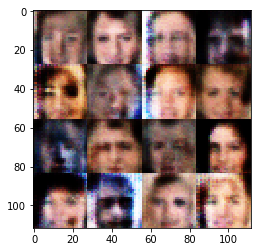

Epoch 1/1... Discriminator Loss: 0.6119... Generator Loss: 1.7908
Epoch 1/1... Discriminator Loss: 1.9258... Generator Loss: 1.1717
Epoch 1/1... Discriminator Loss: 1.1912... Generator Loss: 1.5745
Epoch 1/1... Discriminator Loss: 0.8308... Generator Loss: 1.0675
Epoch 1/1... Discriminator Loss: 0.6354... Generator Loss: 1.4957
Epoch 1/1... Discriminator Loss: 0.8012... Generator Loss: 1.0764
Epoch 1/1... Discriminator Loss: 0.7117... Generator Loss: 1.5121
Epoch 1/1... Discriminator Loss: 0.9963... Generator Loss: 0.8070
Epoch 1/1... Discriminator Loss: 0.5209... Generator Loss: 2.8913
Epoch 1/1... Discriminator Loss: 2.7116... Generator Loss: 0.1151
x1 Shape = (?, 7, 7, 512)
x2 Shape = (?, 14, 14, 256)
x3 Shape = (?, 28, 28, 128)
Output Shape = (?, 28, 28, 3)


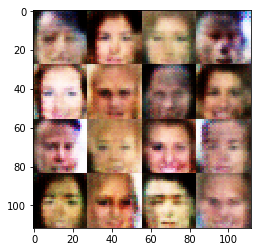

Epoch 1/1... Discriminator Loss: 0.6469... Generator Loss: 1.9478
Epoch 1/1... Discriminator Loss: 1.1027... Generator Loss: 0.7971
Epoch 1/1... Discriminator Loss: 1.0896... Generator Loss: 0.7122
Epoch 1/1... Discriminator Loss: 1.1363... Generator Loss: 1.3435
Epoch 1/1... Discriminator Loss: 1.2851... Generator Loss: 0.5437
Epoch 1/1... Discriminator Loss: 0.5777... Generator Loss: 1.6916
Epoch 1/1... Discriminator Loss: 0.6453... Generator Loss: 1.5206
Epoch 1/1... Discriminator Loss: 1.6591... Generator Loss: 1.7960
Epoch 1/1... Discriminator Loss: 0.5460... Generator Loss: 2.0267
Epoch 1/1... Discriminator Loss: 0.4582... Generator Loss: 4.3698
x1 Shape = (?, 7, 7, 512)
x2 Shape = (?, 14, 14, 256)
x3 Shape = (?, 28, 28, 128)
Output Shape = (?, 28, 28, 3)


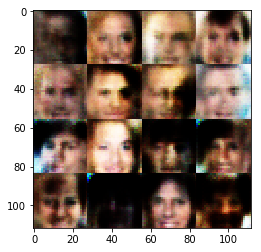

Epoch 1/1... Discriminator Loss: 1.2313... Generator Loss: 0.7779
Epoch 1/1... Discriminator Loss: 1.0282... Generator Loss: 1.4720
Epoch 1/1... Discriminator Loss: 1.1822... Generator Loss: 0.8506
Epoch 1/1... Discriminator Loss: 1.3751... Generator Loss: 3.6972
Epoch 1/1... Discriminator Loss: 0.7878... Generator Loss: 1.6860
Epoch 1/1... Discriminator Loss: 0.7431... Generator Loss: 1.2516
Epoch 1/1... Discriminator Loss: 0.5822... Generator Loss: 1.6678
Epoch 1/1... Discriminator Loss: 0.7371... Generator Loss: 1.7366
Epoch 1/1... Discriminator Loss: 1.3176... Generator Loss: 3.4094
Epoch 1/1... Discriminator Loss: 0.7499... Generator Loss: 1.5686
x1 Shape = (?, 7, 7, 512)
x2 Shape = (?, 14, 14, 256)
x3 Shape = (?, 28, 28, 128)
Output Shape = (?, 28, 28, 3)


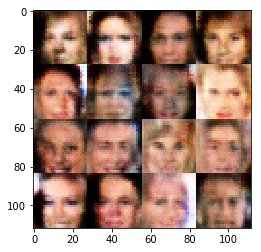

Epoch 1/1... Discriminator Loss: 0.9303... Generator Loss: 1.1081
Epoch 1/1... Discriminator Loss: 0.8086... Generator Loss: 1.0812
Epoch 1/1... Discriminator Loss: 0.3815... Generator Loss: 3.7752
Epoch 1/1... Discriminator Loss: 2.1507... Generator Loss: 0.2524
Epoch 1/1... Discriminator Loss: 1.3768... Generator Loss: 0.8259
Epoch 1/1... Discriminator Loss: 1.3678... Generator Loss: 0.8799
Epoch 1/1... Discriminator Loss: 1.2999... Generator Loss: 0.8847
Epoch 1/1... Discriminator Loss: 1.4174... Generator Loss: 0.8076
Epoch 1/1... Discriminator Loss: 1.3824... Generator Loss: 0.7723
Epoch 1/1... Discriminator Loss: 1.2430... Generator Loss: 0.8687
x1 Shape = (?, 7, 7, 512)
x2 Shape = (?, 14, 14, 256)
x3 Shape = (?, 28, 28, 128)
Output Shape = (?, 28, 28, 3)


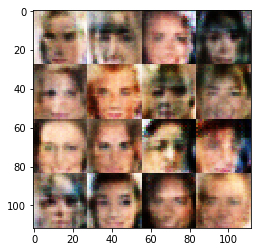

Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 0.8471
Epoch 1/1... Discriminator Loss: 1.5528... Generator Loss: 0.6699
Epoch 1/1... Discriminator Loss: 1.2826... Generator Loss: 0.8963
Epoch 1/1... Discriminator Loss: 1.4872... Generator Loss: 0.7034
Epoch 1/1... Discriminator Loss: 1.3712... Generator Loss: 0.8742
Epoch 1/1... Discriminator Loss: 1.3114... Generator Loss: 0.8761
Epoch 1/1... Discriminator Loss: 1.3647... Generator Loss: 0.8197
Epoch 1/1... Discriminator Loss: 1.4091... Generator Loss: 0.7828
Epoch 1/1... Discriminator Loss: 1.3890... Generator Loss: 0.7906
Epoch 1/1... Discriminator Loss: 1.3444... Generator Loss: 0.8350
x1 Shape = (?, 7, 7, 512)
x2 Shape = (?, 14, 14, 256)
x3 Shape = (?, 28, 28, 128)
Output Shape = (?, 28, 28, 3)


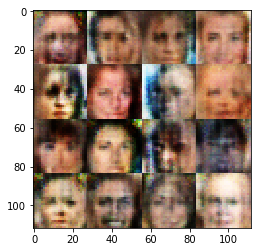

Epoch 1/1... Discriminator Loss: 1.3628... Generator Loss: 0.8540
Epoch 1/1... Discriminator Loss: 1.3874... Generator Loss: 0.8155
Epoch 1/1... Discriminator Loss: 1.3521... Generator Loss: 0.8518
Epoch 1/1... Discriminator Loss: 1.3753... Generator Loss: 0.8721
Epoch 1/1... Discriminator Loss: 1.2962... Generator Loss: 0.8266
Epoch 1/1... Discriminator Loss: 1.3709... Generator Loss: 0.8434
Epoch 1/1... Discriminator Loss: 1.3090... Generator Loss: 0.8808
Epoch 1/1... Discriminator Loss: 1.2552... Generator Loss: 0.9264
Epoch 1/1... Discriminator Loss: 1.3209... Generator Loss: 0.8190
Epoch 1/1... Discriminator Loss: 1.3189... Generator Loss: 0.8956
x1 Shape = (?, 7, 7, 512)
x2 Shape = (?, 14, 14, 256)
x3 Shape = (?, 28, 28, 128)
Output Shape = (?, 28, 28, 3)


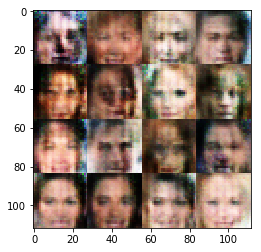

Epoch 1/1... Discriminator Loss: 1.3366... Generator Loss: 0.9219
Epoch 1/1... Discriminator Loss: 1.2205... Generator Loss: 0.8472
Epoch 1/1... Discriminator Loss: 1.1385... Generator Loss: 1.0360
Epoch 1/1... Discriminator Loss: 1.1675... Generator Loss: 1.0385
Epoch 1/1... Discriminator Loss: 1.1857... Generator Loss: 0.7773
Epoch 1/1... Discriminator Loss: 1.1552... Generator Loss: 1.1889
Epoch 1/1... Discriminator Loss: 0.8729... Generator Loss: 1.1372
Epoch 1/1... Discriminator Loss: 1.3060... Generator Loss: 0.6025
Epoch 1/1... Discriminator Loss: 0.7599... Generator Loss: 1.5065
Epoch 1/1... Discriminator Loss: 1.2371... Generator Loss: 2.8839
x1 Shape = (?, 7, 7, 512)
x2 Shape = (?, 14, 14, 256)
x3 Shape = (?, 28, 28, 128)
Output Shape = (?, 28, 28, 3)


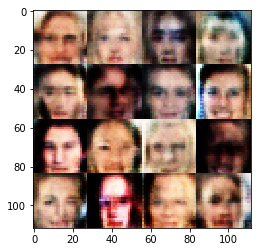

Epoch 1/1... Discriminator Loss: 0.7608... Generator Loss: 1.1755
Epoch 1/1... Discriminator Loss: 0.6739... Generator Loss: 1.5087
Epoch 1/1... Discriminator Loss: 1.2393... Generator Loss: 0.7280
Epoch 1/1... Discriminator Loss: 0.9017... Generator Loss: 0.9560
Epoch 1/1... Discriminator Loss: 1.1957... Generator Loss: 1.1755
Epoch 1/1... Discriminator Loss: 1.1498... Generator Loss: 0.9619
Epoch 1/1... Discriminator Loss: 1.1486... Generator Loss: 0.6883
Epoch 1/1... Discriminator Loss: 0.9864... Generator Loss: 1.0319
Epoch 1/1... Discriminator Loss: 1.0937... Generator Loss: 0.6936
Epoch 1/1... Discriminator Loss: 0.6512... Generator Loss: 1.5088
x1 Shape = (?, 7, 7, 512)
x2 Shape = (?, 14, 14, 256)
x3 Shape = (?, 28, 28, 128)
Output Shape = (?, 28, 28, 3)


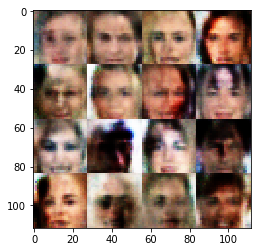

Epoch 1/1... Discriminator Loss: 0.8492... Generator Loss: 1.5357
Epoch 1/1... Discriminator Loss: 0.8967... Generator Loss: 1.9454
Epoch 1/1... Discriminator Loss: 0.4997... Generator Loss: 2.0461
Epoch 1/1... Discriminator Loss: 0.7614... Generator Loss: 1.1832
Epoch 1/1... Discriminator Loss: 0.9364... Generator Loss: 1.0419
Epoch 1/1... Discriminator Loss: 0.7337... Generator Loss: 1.6573
Epoch 1/1... Discriminator Loss: 1.4195... Generator Loss: 0.5011
Epoch 1/1... Discriminator Loss: 0.7108... Generator Loss: 2.8288
Epoch 1/1... Discriminator Loss: 0.6269... Generator Loss: 1.5919
Epoch 1/1... Discriminator Loss: 1.2082... Generator Loss: 0.6801
x1 Shape = (?, 7, 7, 512)
x2 Shape = (?, 14, 14, 256)
x3 Shape = (?, 28, 28, 128)
Output Shape = (?, 28, 28, 3)


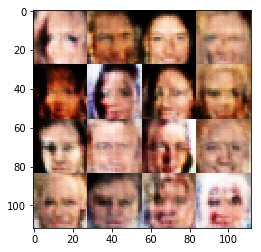

Epoch 1/1... Discriminator Loss: 0.6061... Generator Loss: 2.6238
Epoch 1/1... Discriminator Loss: 0.5003... Generator Loss: 3.3283
Epoch 1/1... Discriminator Loss: 0.6331... Generator Loss: 1.5425
Epoch 1/1... Discriminator Loss: 1.4040... Generator Loss: 1.1353
Epoch 1/1... Discriminator Loss: 0.6839... Generator Loss: 1.8093
Epoch 1/1... Discriminator Loss: 0.8701... Generator Loss: 1.4420
Epoch 1/1... Discriminator Loss: 1.3056... Generator Loss: 0.5820
Epoch 1/1... Discriminator Loss: 0.7863... Generator Loss: 1.3524
Epoch 1/1... Discriminator Loss: 1.2302... Generator Loss: 1.9531
Epoch 1/1... Discriminator Loss: 0.6839... Generator Loss: 3.7380
x1 Shape = (?, 7, 7, 512)
x2 Shape = (?, 14, 14, 256)
x3 Shape = (?, 28, 28, 128)
Output Shape = (?, 28, 28, 3)


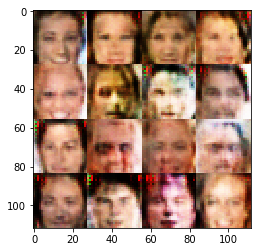

Epoch 1/1... Discriminator Loss: 1.0175... Generator Loss: 1.8608
Epoch 1/1... Discriminator Loss: 0.8437... Generator Loss: 1.1023
Epoch 1/1... Discriminator Loss: 1.0174... Generator Loss: 0.9432
Epoch 1/1... Discriminator Loss: 1.4391... Generator Loss: 0.7687
Epoch 1/1... Discriminator Loss: 1.3221... Generator Loss: 0.9582
Epoch 1/1... Discriminator Loss: 1.2691... Generator Loss: 0.6199
Epoch 1/1... Discriminator Loss: 1.0955... Generator Loss: 0.9895
Epoch 1/1... Discriminator Loss: 1.1243... Generator Loss: 3.6441


In [51]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.